In [113]:
%matplotlib inline

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytpc
import seaborn as sns
import math
import matplotlib.pyplot as plt
import h5py
import heapq

In [115]:
def hough_circle(xyzs):
    nbins = 200
    xyz_order = xyzs[np.argsort(xyzs[:,2])]
    th = np.linspace(0,math.pi,nbins)
    #H = [0,0]
    Hrad = [0,0]
    xyz_order_f = xyz_order[5:]
    xyz_order = xyz_order[:-5]

   # return xyz_order, xyz_order_f
    for theta in th:
        Radius = (xyz_order_f[:,0]**2 - xyz_order[:,0]**2+ xyz_order_f[:,1]**2- xyz_order[:,1]**2)/(2*((xyz_order_f[:,0]- xyz_order[:,0])*np.cos(theta)+(xyz_order_f[:,1]- xyz_order[:,1])*np.sin(theta)))
        index = 0
        for rr in Radius:  
            aRad = np.hstack((theta,Radius[index]))
            Hrad = np.vstack((Hrad,aRad))
            index +=1

    Hrad = Hrad[1:]
    
    #countsRad, xedgesRad, yedgesRad, ImageRad = plt.hist2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-500,500]],cmap=plt.cm.jet) 
    countsRad, xedgesRad, yedgesRad = np.histogram2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-500,500]])

    iRad,jRad = np.unravel_index(countsRad.argmax(), countsRad.shape)

    tRad = iRad*math.pi/nbins
    rRad = jRad*1000/nbins - 500
   
    print(rRad,tRad)
  
    ax =  rRad*math.cos(tRad)  
    by =  rRad*math.sin(tRad)
  
    return ax,by

In [758]:
def hough_line(xy):
    nbins = 500
    th = np.linspace(0,math.pi,nbins)
    Hrad = [0,0]

    for theta in th:
        #if(theta)
        Radius = xy[:,0]*math.cos(theta) + xy[:,1]*math.sin(theta)
        index = 0
        for rr in Radius:
            #print(rr)
            #aRad = np.hstack((theta,rr))
            #print(aRad)
            aRad = np.hstack((theta,Radius[index]))
            #H = np.vstack((H,a))
            Hrad = np.vstack((Hrad,aRad))
            index +=1
    #H = H[1:]
    #print(Hrad)
    Hrad = Hrad[1:]
    
    #countsRad, xedgesRad, yedgesRad, ImageRad = plt.hist2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-500,500]],cmap=plt.cm.jet)
    countsRad, xedgesRad, yedgesRad, ImageRad = plt.hist2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-2000,2000]],cmap=plt.cm.jet) 
    #countsRad, xedgesRad, yedgesRad = np.histogram2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-1000,1000]]) 
    iRad,jRad = np.unravel_index(countsRad.argmax(), countsRad.shape)

    tRad = iRad*math.pi/nbins
    rRad = jRad*4000/nbins - 2000

    return rRad, tRad, countsRad

In [759]:
import scipy.spatial.distance as sp
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


from scipy.spatial.distance import pdist
#x = numpy.array([[9.5,7.5],[10.2,19.1],[9.7,10.2]])

def min_distance(point, array):
    d = []
    #print("point = ", point)
    #print("array = ", array)
    #print(point[0])
    #print(array[:,0])
    #i = 0
    for a in array:
        #print("a = ", a)
        d.append(math.sqrt((a[0]-point[0])**2 + (a[1]-point[1])**2))
        #i += 1
    return min(d)

def find_good_points(counts, r_th):
    N = 70

    ind = np.argpartition(counts.flatten(),-N)[-N:]
    indices = np.vstack(np.unravel_index(ind,counts.shape)).T
    #print(indices)
    r_signal = [0,0]
    r_temp = r_th

    nbins = 500
    tRad = indices[:,0]*math.pi/nbins
    rRad = indices[:,1]*4000/nbins - 2000
    
    
    test = np.zeros(indices.shape)
    test[:,0] = indices[:,0]*math.pi/nbins
    test[:,1] = indices[:,1]*4000/nbins - 2000
    #print(test)
    x = np.linspace(50,1600,100)
    y = np.zeros(100)
    plt.plot(r_th[:,0],r_th[:,1],'r.')
    sig_i = []
    for idx, rr in enumerate(rRad): 
        #if not((rr in rRad[:idx]) or (np.where(np.logical_and(rRad[:idx]>rr-3, rRad[:idx]<rr+3)))):
        #if not(((rRad[:idx] > rr-5).any() and (rRad[:idx] < rr+5).any()) ):
        mindist = 1000
        if(idx > 1):
           
            d = test[:idx]
            current = (tRad[idx],rRad[idx])
            mindist = min_distance(current,d)
            #print(mindist)
        if(mindist > 30):
        #if not(((tRad[:idx] > tRad[idx]-5).any() and (tRad[:idx] < tRad[idx]+5).any()) ):
        #np.where((rRad[:idx] > rr-5) and (rRad[:idx] < rr+5)))
        #if not(rr in rRad[:idx]):
           # print(rr, tRad[idx])
            y_temp= (rRad[idx]-x*math.cos(tRad[idx]))/math.sin(tRad[idx])
            y = np.vstack((y,y_temp))
            #plt.plot(x,y_temp,'-')
            b = math.sin(tRad[idx])
            c = -rr
            a = math.cos(tRad[idx])

            y2 = (c/b)-a*x/b
            plt.plot(x,y2,'r')

            idxx = []
            indd = 0;
            for rr in r_th:       
                yy = (a*(-b*rr[0]+a*rr[1])-b*c)/(a**2+b**2)
                xx = (b*(b*rr[0]-a*rr[1])-a*c)/(a**2+b**2)
    
                if(math.sqrt((xx-rr[0])**2 +(yy-rr[1])**2) < 15):
                    plt.plot(rr[0],rr[1],'g.')
                    idxx.append(indd)
                    if ((indd in sig_i) is False):
                        sig_i.append(indd)
                        r_signal = np.vstack((r_signal,rr))
                indd = indd+1
            
            #plt.plot(r_th[idxx,0],r_th[idxx,1],'g.')
            #print(idxx)
            #db = DBSCAN(eps=10, min_samples=4).fit(r_th[idxx])
            #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            #core_samples_mask[db.core_sample_indices_] = True
            #labels = db.labels_
            mm = a/b
            A = np.vstack([r_th[idxx,0], np.ones(len(r_th[idxx,0]))]).T
            if(A.any()):
                m, yint = np.linalg.lstsq(A, r_th[idxx,1])[0]
                if(m>0):
                    #print('line params = ',m,yint)
                    plt.plot(x, m*x+ yint, '-r')
                    idxx = []
                    indd = 0;
                    for rr in r_th:       
                    #yy = (a*(-b*rr[0]+a*rr[1])-b*c)/(a**2+b**2)
                    #xx = (b*(b*rr[0]-a*rr[1])-a*c)/(a**2+b**2)
                        yy = (rr[0]*m + rr[1]*m*m+yint)/(m*m+1)
                        xx = (rr[0]+rr[1]*m-yint*m)/(m*m+1)
                        if(math.sqrt((xx-rr[0])**2 +(yy-rr[1])**2) < 5):
                        #plt.plot(rr[0],rr[1],'g.')
                            idxx.append(indd)
                            if ((indd in sig_i) is False):
                                sig_i.append(indd)
                                r_signal = np.vstack((r_signal,rr))
                        indd = indd+1
                    plt.plot(r_th[idxx,0],r_th[idxx,1],'g.')
                    #print(idxx)
                      #, label='Fitted line')
            # Number of clusters in labels, ignoring noise if present.
           # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

            #print('Estimated number of clusters: %d' % n_clusters_)
            #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
            #Y = sp.pdist(r_th[idxx], 'euclidean')
            #print(Y)
    #plt.ylim((-1000,1000))         
   # plt.axes().set_aspect(1)
    return sig_i, rRad, tRad

In [118]:
h5_filename = '../run_0166_peaks_bkd_subtract.h5'
group_name = '/reduced_get_events'
file = h5py.File(h5_filename,'r')
group = file[group_name]

In [119]:
#i = 0

In [766]:
#ev = '128'
#i = 29
#i += 1
i = 63
print(i)
ev = str(i)
event = group[ev]
xyz = event[:,0:4]

#fig = plt.figure()
#ax = fig.add_subplot(111,projection='3d')
#cmhot = plt.get_cmap("jet")
#a = ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],c=xyz[:,3],cmap=cmhot)
#fig.colorbar(a)

63


[[ 1.          0.          0.        ]
 [ 0.          0.99452187 -0.10452871]
 [ 0.          0.10452871  0.99452187]]
[ 88.15278412 -56.5237008   76.81217954]
[ 87.30099391 -56.75034358  20.          25.        ]


C:\Users\perrym\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


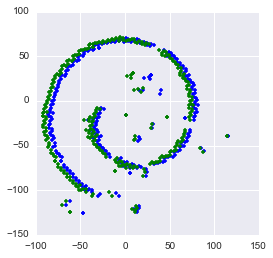

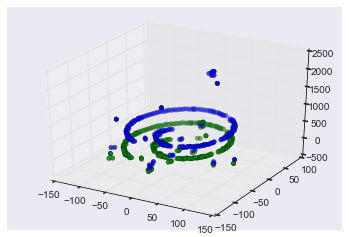

In [767]:
v_drift = pytpc.simulation.drift_velocity_vector(-5.2,9000,1.75,0.10472)
uvw = pytpc.evtdata.calibrate(xyz,v_drift,12.5)
tmat = pytpc.utilities.tilt_matrix(-0.10472)
print(tmat)
#print(np.shape(uvw))
uvw = np.dot(tmat,uvw[:,:3].T).T
print(uvw[1,:])
print(xyz[1,:])
#uvw[:, 0], uvw[: ,1], uvw[:, 2] = np.inner(tmat, uvw[:, :3].T)
plt.plot(uvw[:,0],uvw[:,1],'b.')#,a,b,'r.')
plt.plot(xyz[:,0],xyz[:,1],'g.')#,a,b,'r.')
plt.axes().set_aspect(1)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a = ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],c='g')
ax.scatter(uvw[:,0],uvw[:,1],uvw[:,2])

In [768]:
a,b = hough_circle(xyz);
print(a,b)

-10.0 1.35088484104
-2.18143241397 -9.75916761939


-30.0 2.02632726157
13.1981750957 -26.9408272728


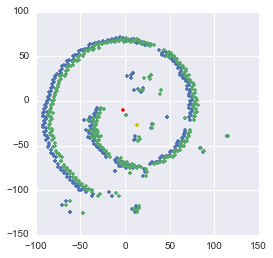

In [769]:
#uncal_center = [uncal_center,0]
#uncal_center = np.array([[a,b,200],[0,0,0]])

#print(xyz)
#print(uncal_center)
#uncal_center[:]
aa,bb = hough_circle(uvw);
print(aa,bb)
#center = pytpc.evtdata.calibrate(uncal_center,v_drift,12.5)

#nc = center[0,:]
#print(a,b,nc)
plt.plot(xyz[:,0],xyz[:,1],'.',a,b,'r.')
plt.plot(uvw[:,0],uvw[:,1],'.',aa,bb,'y.')
plt.axes().set_aspect(1)


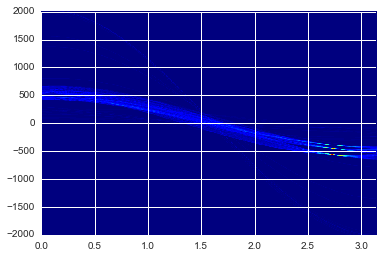

In [770]:
rad_z = [0,0]
th_z= [0,0]
for xy in uvw:
    r_xy = np.sqrt((xy[0]-aa)**2+(xy[1]-bb)**2)
    rad_z = np.vstack((rad_z,[xy[2],r_xy]))
    th_xy = np.arctan((xy[1]-bb)/(xy[0]-aa))
    #print(th_xy)
    th_z = np.vstack((th_z,[xy[2],th_xy]))

rad_z = rad_z[1:] 
th_z = th_z[1:] 
#plt.plot(rad_z[:,0],rad_z[:,1],'.')
rad_z = rad_z[1:]    
th_z = th_z[1:]  
r_th = th_z
r_th[:,1] = r_th[:,1]*rad_z[:,1]

r,t, counts = hough_line(r_th)
plt.plot(r_th[:,0],r_th[:,1],'.')

In [771]:
#print(rad_z)
#print(th_z.shape)

#y.shape
#plt.plot(np.log(rad_z[:,1]),th_z[:,1],'.')
#%matplotlib inline
#plt.plot(th_z[:,0],th_z[:,1],'.')
#plt.xlim(600,1200)
#plt.ylim(-200,200)

In [772]:
#plt.plot(np.log(rad_z[:,1]),th_z[:,1],'.')

(200, 800)

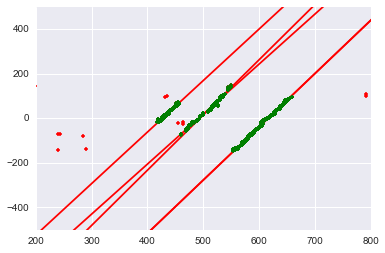

In [789]:

#%matplotlib inline
sig_i, rRad, tRad = find_good_points(counts, th_z)
plt.ylim(-500,500)
plt.xlim(200,800)
#plt.gca().set_aspect(.1)
#plt.ylim(-500,500)

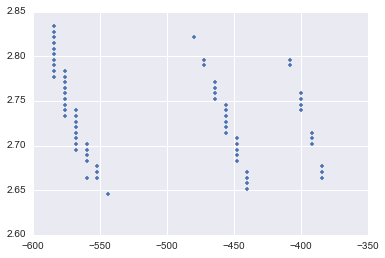

In [779]:
#plt.xlim((470,500))
#plt.ylim((60,90))
#plt.axes().set_aspect(1)
plt.plot(rRad,tRad,'.')
#plt.xlim(-52,-49)

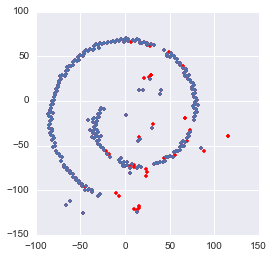

In [780]:
test_sig = uvw[sig_i]
plt.plot(uvw[:,0],uvw[:,1],'r.',test_sig[:,0],test_sig[:,1],'.')#,a,b,'.g')
plt.axes().set_aspect(1)
#indices

C:\Users\perrym\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


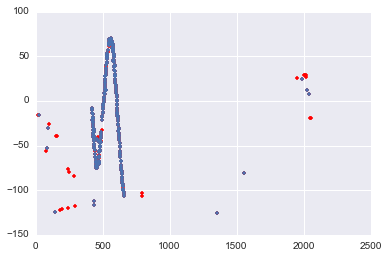

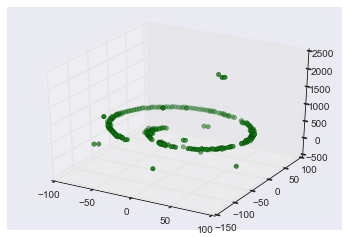

In [783]:
plt.plot(uvw[:,2],uvw[:,1],'r.',test_sig[:,2],test_sig[:,1],'.')
#i = i+1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a = ax.scatter(test_sig[:,0],test_sig[:,1],test_sig[:,2],c='g')

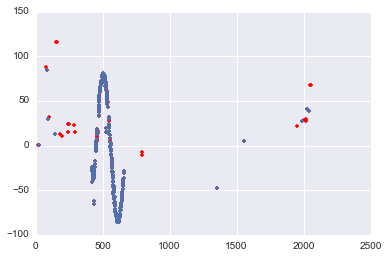

In [782]:
plt.plot(uvw[:,2],uvw[:,0],'r.',test_sig[:,2],test_sig[:,0],'.')

In [790]:
print(test_sig)

[[  8.49537128e+01  -5.29045772e+01   8.54678730e+01]
 [ -7.64435775e+01  -5.85144200e+01   6.31048541e+02]
 [ -7.36840830e+01  -5.94061223e+01   6.30954819e+02]
 [ -7.70109228e+01  -5.57743623e+01   6.27198880e+02]
 [ -7.31593271e+01  -6.21419679e+01   6.30667269e+02]
 [ -7.03998326e+01  -6.30336703e+01   6.30573548e+02]
 [ -8.24412582e+01  -3.09517709e+01   6.17394884e+02]
 [ -8.06311464e+01  -3.92259680e+01   6.20662883e+02]
 [ -8.19165024e+01  -3.36876165e+01   6.17107335e+02]
 [ -8.00638010e+01  -4.19660258e+01   6.24512544e+02]
 [ -8.39153968e+01  -3.55984201e+01   6.21044154e+02]
 [ -8.33906409e+01  -3.83342657e+01   6.20756605e+02]
 [ -2.86413358e+01  -1.03009330e+01   4.20958003e+02]
 [ -5.85995042e+01   4.33693436e+01   5.83829830e+02]
 [ -5.80321588e+01   4.06292858e+01   5.87679491e+02]
 [ -6.28331372e+01   3.96143967e+01   5.87572822e+02]
 [ -6.48746211e+01   3.77078052e+01   5.87372430e+02]
 [ -6.01162322e+01   3.87269065e+01   5.83341889e+02]
 [ -5.38411152e+01   4.43884

In [792]:
uvw_order = uvw[np.argsort(uvw[:,2])]
print(uvw_order)

[[  1.08512498e+00  -1.57005525e+01   1.90380700e+01]
 [  1.12771449e+00  -1.57047646e+01   2.31752810e+01]
 [  8.81527841e+01  -5.65237008e+01   7.68121795e+01]
 [  8.49537128e+01  -5.29045772e+01   8.54678730e+01]
 [  2.99164288e+01  -2.99777409e+01   9.20152400e+01]
 [  3.15183359e+01  -2.53437282e+01   1.00777603e+02]
 [  1.31069172e+01  -1.24487434e+02   1.44146653e+02]
 [  1.15432988e+02  -3.95043540e+01   1.53078756e+02]
 [  1.15475577e+02  -3.95085662e+01   1.57215967e+02]
 [  1.29228774e+01  -1.21785286e+02   1.77531890e+02]
 [  1.03763305e+01  -1.20914644e+02   1.98311667e+02]
 [  1.56032040e+01  -1.19941876e+02   2.39790446e+02]
 [  2.38854329e+01  -7.64347743e+01   2.40225584e+02]
 [  2.44527782e+01  -7.91748320e+01   2.44075246e+02]
 [  2.33619453e+01  -8.38593905e+01   2.84959414e+02]
 [  1.55895223e+01  -1.17256577e+02   2.89724528e+02]
 [ -2.66424414e+01  -8.39012934e+00   4.17021183e+02]
 [ -4.12767488e+01  -2.16155854e+01   4.19768782e+02]
 [ -2.81165799e+01  -1.30367